In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import fAux
import mc_permutation
import detrendPrice 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, RocCurveDisplay, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score, 
)
from sklearn.utils.class_weight import compute_class_weight


from xgboost import XGBClassifier, plot_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr

from arch import arch_model

import ta
from ta.trend import EMAIndicator 
global global_returns
global global_labels

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_cols)
    
def get_data(ticker, start_date='1999-01-01', end_date=None, save_csv=False):
    os.makedirs("data", exist_ok=True)
    filename = f"data/{ticker.lower()}.csv"
    # if os.path.exists(filename):
    #     print(f"Data for {i} already exists, skipping download.")
    #     continue

    data = yf.download(ticker.upper(), start=start_date, end=end_date, auto_adjust=True)

    # Handle empty or failed download
    if data.empty:
        print(f"No data found for {ticker}")
        return pd.DataFrame()
    
    # Flatten column headers if it's a MultiIndex (e.g., from group_by='ticker')
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    data['Ticker'] = ticker.lower()
    data.index = pd.to_datetime(data.index)
    data.columns = [col.lower() for col in data.columns]


    if save_csv:
        data.to_csv(filename, index=False)
        print(f"Saved data for {ticker} to {filename}")
        
    return data




In [2]:
# spy = get_data('spy', end_date = '2025-07-20')
# nvda = get_data('nvda', end_date = '2025-07-20')
# pd.concat([nvda.head(),nvda.tail()])

In [3]:
# model for longing; trading at open tomorrow (t+1)
# based on today's data (ohlcv and more), decide whether to long tomorrow
# binary target: 1 if price reverts up (above the threshold e.g. gain over 2%) wihtin the next five trading days, 0 otherwise
def create_target_long(df, threshold=0.02, lookahead=5):
    """
    Label as 1 if max return over the next 'lookahead' days is >= threshold.
    Else, label as 0.
    """
    df = df.copy()
    entry_price = df['open'].shift(-1) # trade at open next day
    future_max = df['open'].shift(-1).rolling(window=lookahead).max() 
    future_return = (future_max - entry_price) / entry_price
    df['target_long'] = (future_return >= threshold).astype(int)
    return df


def feature_engineering(df): # for trading at open tomorrow
    # original_feats = df.columns

    # phase 1: add features thats fundamental to mean reversion trading with bollinger bands and rsi
    df['sma30'] = df['close'].rolling(30).mean()
    df['sma10'] = df['close'].rolling(10).mean()
    df['sma_diff'] = df['sma10'] - df['sma30']
    df['sma_slope'] = df['sma10'].diff()
    df['std30'] = df['close'].rolling(30).std()
    df['bollinger_upper'] = df['sma30'] + 2 * df['std30']
    df['bollinger_lower'] = df['sma30'] - 2 * df['std30']
    df['percent_b'] = (df['close'] - df['bollinger_lower']) / (df['bollinger_upper'] - df['bollinger_lower'])
    df['bollinger_z'] = (df['close'] - df['sma30']) / df['std30']
    df['price_near_lower_bb'] = (df['close'] <= df['bollinger_lower'] * 1.01).astype(int)

    df['rsi14'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()    
    df['prod_bollingerz_rsi'] = df['percent_b'] * df['rsi14']

    # phase 2: add other technical features  
    df['daily_return'] = df['open'].pct_change()
    df['rolling_volatility14'] = df['daily_return'].rolling(window=30).std()
    df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()

    # spy_ret5 (discard for now; if wanting to add add it from feature_engineering_add_macro)
    # spy_ret5 = df_spy['open'].pct_change(periods=5)
    # df = df.merge(spy_ret5.rename('spy_ret5'), left_index=True, right_index=True, how='left')

    # phase 3: more features!
    
    # 3.1 GARCH(1,1) on returns
    returns = df['close'].pct_change().dropna() * 100 # in percent
    am = arch_model(returns, vol='Garch', p=1, q=1)
    res = am.fit(disp='off')
    df['garch_vol'] = res.conditional_volatility # in percent

    # 3.2 tiem related features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['dayofweek'] = df.index.dayofweek


    # df.dropna(inplace=True)
    # new_feats = [i for i in df.columns if i not in original_feats]
    return df


def feature_engineering_add_macro(df,etf:str):
    df_etf = get_data(etf, end_date = df.index.max())
    df_etf['sma10'] = df_etf['close'].rolling(10).mean()
    df_etf['sma20'] = df_etf['close'].rolling(20).mean()
    df_etf['sma50'] = df_etf['close'].rolling(50).mean()
    df_etf['sma200'] = df_etf['close'].rolling(200).mean()
    df_etf['trend_10_50'] = (df_etf['sma10'] > df_etf['sma50']).astype(int)
    df_etf['trend_20_50'] = (df_etf['sma20'] > df_etf['sma50']).astype(int)
    df_etf['trend_50_200'] = (df_etf['sma50'] > df_etf['sma200']).astype(int)
    df = df.merge(df_etf['trend_10_50'].rename(f'{etf}_trend_10_50'), left_index=True, right_index=True, how='left')
    df = df.merge(df_etf['trend_20_50'].rename(f'{etf}_trend_20_50'), left_index=True, right_index=True, how='left')
    df = df.merge(df_etf['trend_50_200'].rename(f'{etf}_trend_50_200'), left_index=True, right_index=True, how='left')
    return df



def plot_model_metrics(y_true, y_proba):
    y_pred = (y_proba >= 0.5).astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], colorbar=False)

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_disp.plot(ax=axes[1])

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_disp.plot(ax=axes[2])

    plt.tight_layout()
    plt.show()


def eval_pipe(X, y, pipe, n_split=5, predict_proba_threshold=0.5):
    '''
    for evaluations on train set, make sure X and y does not contain anything from the test set (future data), 
    and use n_split=5 for 5-fold time series cross-validation
    '''
    tscv = TimeSeriesSplit(n_splits=n_split)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= predict_proba_threshold).astype(int)

        print(f'Fold {i+1}:\n{classification_report(y_test, y_pred)}')

        if i == 0:
            print('Fold 1 visualized below')
            plot_model_metrics(y_test, y_proba)

def pred_proba_to_signal(y_proba, threshold=0.5):
    """
    Convert predicted probabilities to binary signals.
    1 if probability >= threshold, else 0.
    returns a Series of signals.
    """
    return (y_proba >= threshold).astype(int)


def entry_exit(df, use_vol=None, take_profit=1, stop_loss=1): 
    '''
    FOR EACH INSTRUMENT (don't use the aggregated one that contains multiple tickers)
    takes in the X_test or ohlcv dataframe containing model signals,
    returns a df that contains entry and exit dates, prices, returns, and holding days
    use_vol: either 'atr' or 'garch_vol'
    take_profit and stop loss as percentage
    '''
    # if date as index
    if pd.api.types.is_datetime64_any_dtype(df.index): 
        df = df.reset_index().rename(columns={'Date': 'date'})

    trades = []
    i = 0
    n = len(df)
    if use_vol not in [None, 'atr', 'garch_vol']:
        raise ValueError("use_vol must be one of: None, 'atr' or 'garch_vol'")
    
    if use_vol == 'atr':
        multiplier = df['atr']
    elif use_vol == 'garch_vol':
        multiplier = df['garch_vol']
    else:
        multiplier = pd.Series(1, index=df.index)

    while i < n - 6:  # we need at least 5 days ahead, plus trading at open tomorrow
        if df['model_signal'].iloc[i] == 1:
            entry_date = df['date'].iloc[i+1]
            entry_price = df['open'].iloc[i+1]
            exit_price = None
            exit_date = None
            holding = None
            exit_reason = None

            for j in range(1, 6):  # check up to 5 days ahead
                if i + 1 + j >= n:
                    break

                next_price = df['open'].iloc[i + 1 + j]
                ret = (next_price - entry_price) / entry_price

                # Exit Conditions
                if ret >= take_profit * 0.01 * multiplier.iloc[i]:  # profit target
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'profit_target'
                    break
                elif ret <= -stop_loss * 0.01 * multiplier.iloc[i]:  # stop loss
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'stop_loss'
                    break
                elif df['open'].iloc[i + 1 + j] >= df['sma30'].iloc[i + 1 + j]:  # revert to SMA30
                    exit_price = next_price
                    exit_date = df['date'].iloc[i + 1 + j]
                    holding = j
                    exit_reason = 'revert_to_sma30'
                    break

            if exit_price is None:
                # Max holding (5th day)
                exit_price = df['open'].iloc[i + 1 + 5]
                exit_date = df['date'].iloc[i + 1 + 5]
                holding = 5

            trade_return = (exit_price - entry_price) / entry_price
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'return': trade_return,
                'holding_days': holding,
                'exit_reason': exit_reason
            })

            i = i + holding  # skip to the day after exit
        else:
            i += 1

    return pd.DataFrame(trades)



def get_cagr(df):
    start_date = df['entry_date'].min()
    end_date = df['exit_date'].max()
    n_years = (end_date - start_date).days / 365.25
    capital = 1
    for r in df['return']:
        capital *= (1 + r)
    cagr = capital ** (1 / n_years) - 1
    return cagr

def get_sharpe(df):
    return df['return'].mean() / df['return'].std()
    


In [4]:
df = get_data('nvda',end_date='2025-07-17')
print(f'original cols (index is date): {df.columns}')
print(f'length of data: {len(df)}')
df = create_target_long(df)
df = feature_engineering(df)
df = feature_engineering_add_macro(df, 'spy')
df = feature_engineering_add_macro(df, 'qqq')
print(f'shape: {df.shape}')

[*********************100%***********************]  1 of 1 completed


original cols (index is date): Index(['close', 'high', 'low', 'open', 'volume', 'ticker'], dtype='object')
length of data: 6661


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

shape: (6661, 33)


In [5]:
X = df.drop(columns=['target_long','ticker'])
y = df['target_long']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(X.columns)

Index(['close', 'high', 'low', 'open', 'volume', 'sma30', 'sma10', 'sma_diff',
       'sma_slope', 'std30', 'bollinger_upper', 'bollinger_lower', 'percent_b',
       'bollinger_z', 'price_near_lower_bb', 'rsi14', 'prod_bollingerz_rsi',
       'daily_return', 'rolling_volatility14', 'atr', 'garch_vol', 'year',
       'month', 'week', 'dayofweek', 'spy_trend_10_50', 'spy_trend_20_50',
       'spy_trend_50_200', 'qqq_trend_10_50', 'qqq_trend_20_50',
       'qqq_trend_50_200'],
      dtype='object')


---
# Gen 1

In [6]:
drop_feats = [
    # 'date',
    'high','low','sma30','sma10','std30',
    'bollinger_upper','bollinger_lower']

ct_xgb1 = make_column_transformer(
    ('drop', drop_feats),  
    remainder='passthrough'  
)

pipe_xgb1 = Pipeline([
    ('ct', ct_xgb1),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1:
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       436
           1       0.76      0.61      0.68       452

    accuracy                           0.70       888
   macro avg       0.71      0.70      0.70       888
weighted avg       0.71      0.70      0.70       888

Fold 1 visualized below


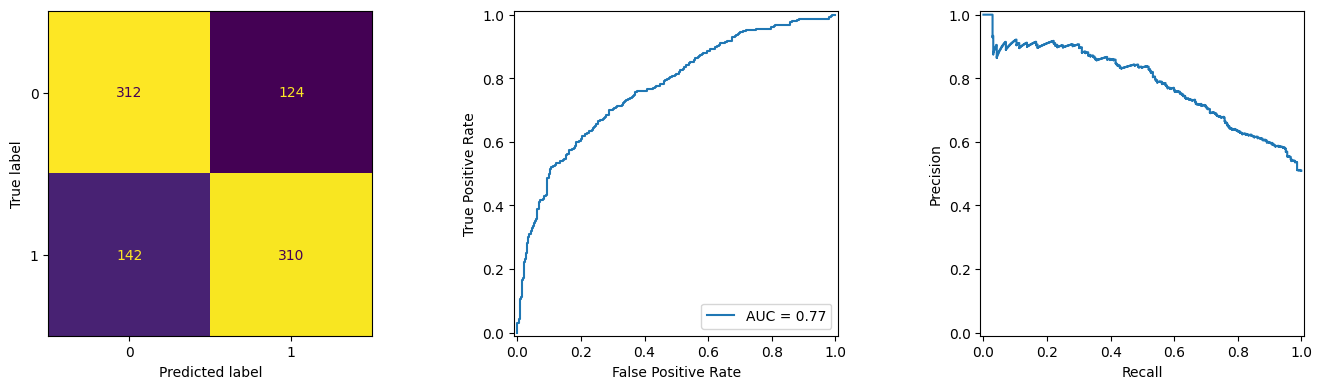

/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       414
           1       0.76      0.76      0.76       474

    accuracy                           0.75       888
   macro avg       0.75      0.75      0.75       888
weighted avg       0.75      0.75      0.75       888



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       433
           1       0.82      0.73      0.77       455

    accuracy                           0.78       888
   macro avg       0.78      0.78      0.78       888
weighted avg       0.79      0.78      0.78       888

Fold 4:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       634
           1       0.68      0.66      0.67       254

    accuracy                           0.82       888
   macro avg       0.77      0.77      0.77       888
weighted avg       0.81      0.82      0.81       888



/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       543
           1       0.71      0.68      0.69       345

    accuracy                           0.77       888
   macro avg       0.75      0.75      0.75       888
weighted avg       0.76      0.77      0.76       888



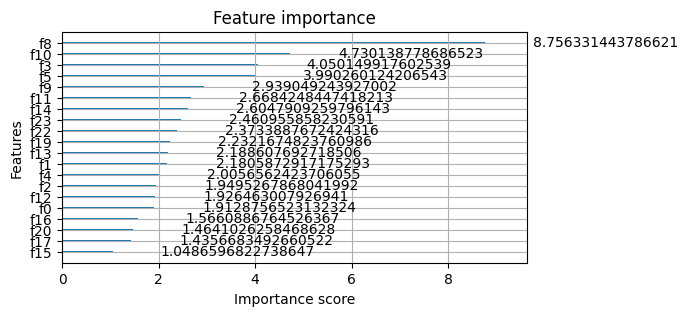

In [7]:
eval_pipe(X_train, y_train, pipe_xgb1, predict_proba_threshold=0.7)

# check feature importance
fig, ax = plt.subplots(figsize=(6,3)) 
xgb1 = pipe_xgb1.named_steps['xgb']
plot_importance(xgb1, importance_type='gain', max_num_features=20, ax=ax)
plt.show()

In [8]:
# hyperparameter tuning
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 300, 500],
    'xgb__subsample': [0.5, 0.7, 1.0],
    'xgb__colsample_bytree': [0.5, 0.7, 1.0]
}

rscv_xgb1 = RandomizedSearchCV(
    pipe_xgb1,
    param_distributions=param_grid,
    n_iter=30,  # number of random combinations to try
    scoring='f1',  # or 'roc_auc', 'accuracy', etc.
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run search
rscv_xgb1.fit(X_train, y_train)

# Best model
print("Best Parameters:")
print(rscv_xgb1.best_params_)

print("\nBest Score:")
print(rscv_xgb1.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best Parameters:
{'xgb__subsample': 1.0, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 1.0}

Best Score:
0.5606860398832479


/Users/stevey/cpsc330arm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:08:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
# backtest
y_proba_xgb1 = rscv_xgb1.predict_proba(X_test)[:, 1]
print(f'max proba: {y_proba_xgb1.max()}')
signals_xgb1 = pred_proba_to_signal(y_proba_xgb1, threshold=0.5)
X_test_signal_xgb1 = X_test.copy().assign(model_signal=signals_xgb1, y_proba=y_proba_xgb1)

# trades_xgb1 = entry_exit(X_test_signal_xgb1)
# trades_xgb1 = entry_exit(X_test_signal_xgb1, use_vol='garch_vol', take_profit=1.5, stop_loss=1)
trades_xgb1 = entry_exit(X_test_signal_xgb1, use_vol='garch_vol', take_profit=1, stop_loss=1)

print(f'number of trades: {len(trades_xgb1)}')
print(trades_xgb1['exit_reason'].value_counts()) # 3 possible outcomes: profit_target, stop_loss, revert_to_sma30
print(trades_xgb1['holding_days'].value_counts())
trades_xgb1[20:30]  # display some trades

max proba: 0.7890609502792358
number of trades: 317
exit_reason
revert_to_sma30    121
profit_target      102
stop_loss           82
Name: count, dtype: int64
holding_days
1    213
2     50
5     21
4     18
3     15
Name: count, dtype: int64


,entry_date,exit_date,entry_price,exit_price,return,holding_days,exit_reason
20,2020-09-08,2020-09-09,11.699450,12.362962,0.056713,1,profit_target
21,2020-09-09,2020-09-10,12.362962,12.950448,0.047520,1,profit_target
22,2020-09-11,2020-09-14,12.448203,13.041928,0.047696,1,profit_target
23,2020-09-14,2020-09-15,13.041928,13.240333,0.015213,1,revert_to_sma30
24,2020-09-17,2020-09-18,12.096011,12.556131,0.038039,1,revert_to_sma30
25,2020-09-18,2020-09-21,12.556131,11.889378,-0.053102,1,stop_loss
26,2020-09-21,2020-09-22,11.889378,12.537438,0.054507,1,profit_target
27,2020-09-22,2020-09-23,12.537438,12.537936,0.000040,1,revert_to_sma30
28,2020-09-25,2020-09-28,12.410318,13.001298,0.047620,1,profit_target
29,2020-10-05,2020-10-06,13.196462,13.788690,0.044878,1,profit_target


In [13]:
print(f"cagr: {get_cagr(trades_xgb1)}")
print(f"sharpe: {get_sharpe(trades_xgb1)}")

cagr: 0.3747722706643506
sharpe: 0.13102234029069695


### comment
- SHARPE ratio can be improved 

---
# refine the model

---
# try in real life

In [11]:
nvda_today = get_data('nvda')
spy_today = get_data('spy')
df_today = create_target_long(nvda_today, threshold=0.02, lookahead=5)
df = feature_engineering_2(feature_engineering(df))
X = df.drop(columns=['target_long','ticker'])
y = df['target_long']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False 



SyntaxError: incomplete input (3580733098.py, line 8)

---
# ARCHIVE